## Sentiment Analysis and Classification of Restaurant Reviews

AI Natural Language Processing Group Project

### 1. Data collection and cleaning

Data Handling: Initial steps include loading the dataset and handling missing data specifically in 'Review' and 'Rating', as these are crucial for any analysis or model training.

Loading the Data: The dataset is loaded and basic information is displayed.

In [ ]:
!pip install transformers torch

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from babel.dates import format_time

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [47]:
# Load the dataset
df = pd.read_csv('Restaurant reviews.csv')
print("Original dataset size:", df.shape[0])
print()

# Display the first few rows of the dataset and information about the columns
df.head(), df.info(), df.describe(include='all')

Original dataset size: 10000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  10000 non-null  object 
 1   Reviewer    9962 non-null   object 
 2   Review      9955 non-null   object 
 3   Rating      9962 non-null   object 
 4   Metadata    9962 non-null   object 
 5   Time        9962 non-null   object 
 6   Pictures    10000 non-null  int64  
 7   7514        1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


(        Restaurant              Reviewer  \
 0  Beyond Flavours     Rusha Chakraborty   
 1  Beyond Flavours  Anusha Tirumalaneedi   
 2  Beyond Flavours       Ashok Shekhawat   
 3  Beyond Flavours        Swapnil Sarkar   
 4  Beyond Flavours                Dileep   
 
                                               Review Rating  \
 0  The ambience was good, food was quite good . h...      5   
 1  Ambience is too good for a pleasant evening. S...      5   
 2  A must try.. great food great ambience. Thnx f...      5   
 3  Soumen das and Arun was a great guy. Only beca...      5   
 4  Food is good.we ordered Kodi drumsticks and ba...      5   
 
                   Metadata             Time  Pictures    7514  
 0   1 Review , 2 Followers  5/25/2019 15:54         0  2447.0  
 1  3 Reviews , 2 Followers  5/25/2019 14:20         0     NaN  
 2  2 Reviews , 3 Followers  5/24/2019 22:54         0     NaN  
 3    1 Review , 1 Follower  5/24/2019 22:11         0     NaN  
 4  3 Reviews , 2

Handling Missing Data: Rows missing crucial information for 'Review' and 'Rating' are dropped.

In [48]:
# Handle missing values by dropping or filling
df = df.dropna(subset=['Review', 'Rating'])  # Adjust according to analysis
df_size = df.shape[0]
print("Size after cleaning missing values:", df.shape[0])

Size after cleaning missing values: 9955


Data Conversion: Ratings are converted to numerical values if they're not already in that format.

In [49]:
# Convert Rating to a numerical format if not already
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Explore the distribution of Ratings
print(df['Rating'].value_counts())

Rating
5.0    3826
4.0    2373
1.0    1735
3.0    1192
2.0     684
4.5      69
3.5      47
2.5      19
1.5       9
Name: count, dtype: int64


Rating Distribution: The distribution of ratings is printed and visualized to see the spread and frequency of different ratings.

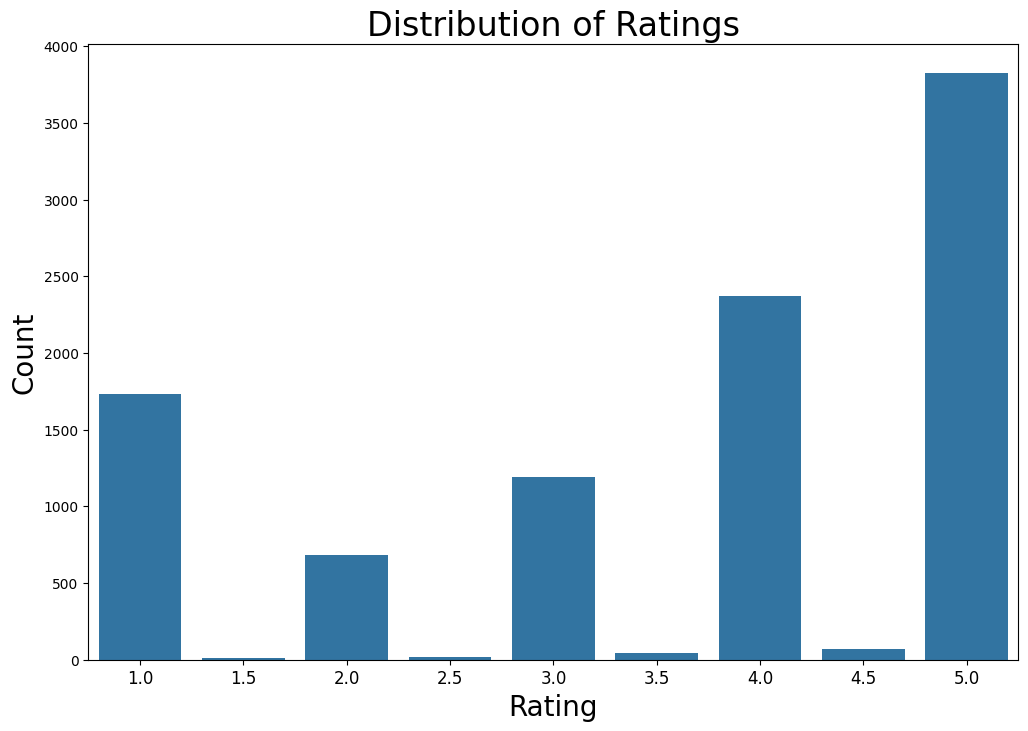

In [50]:
# Visualize the distribution of Ratings
plt.figure(figsize=(12,8))
sns.countplot(x='Rating', data=df)
plt.title('Distribution of Ratings', fontsize=24)
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=12)
plt.show()

The most common rating is 5, which suggests that there is a high occurrence of very positive reviews in this dataset. This could indicate customer satisfaction or potentially that people who are pleased with their experience are more likely to leave a review.

The second most common rating is 4, followed by 1. This further supports the suggestion that reviewers tend to leave feedback when they have had a positive experience.

Ratings of 2 and 3 are the least common, which is often the case in review distributions where extreme opinions are more frequently shared than moderate ones. This phenomenon is known as polarized reviews.

The graph exhibits a left-skewed distribution with more ratings clustered towards the higher end of the scale.

This distribution might suggest that the restaurant or group of restaurants being reviewed is performing well from a customer satisfaction standpoint. However, it could also mean that the dataset is subject to a positive bias, which is common in voluntary review systems.

Restaurant         Rating
10 Downing Street  4.0       0.49
                   5.0       0.25
                   3.0       0.14
                   1.0       0.07
                   2.0       0.05
                             ... 
eat.fit            5.0       0.30
                   1.0       0.27
                   4.0       0.21
                   3.0       0.15
                   2.0       0.07
Name: proportion, Length: 542, dtype: float64


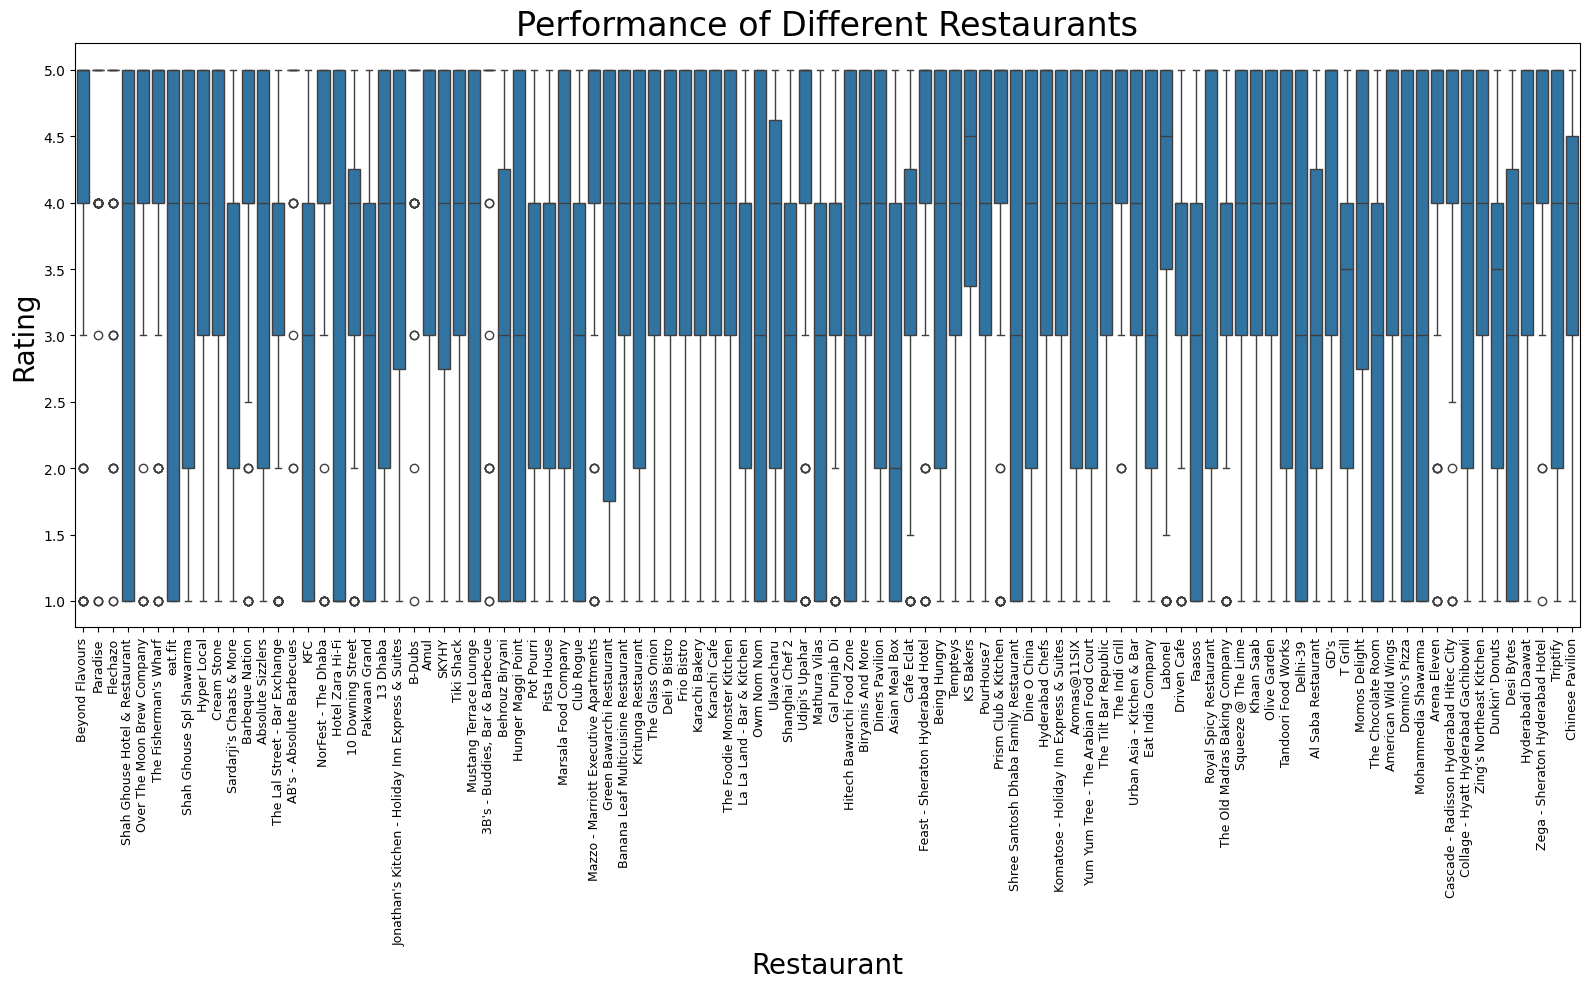

In [51]:
# If other categorical variables like 'city' or 'Restaurant' exist:
if 'Restaurant' in df.columns:
    # Review performances by Restaurants
    print(df.groupby(['Restaurant'])['Rating'].value_counts(normalize=True))

    # Adjusting the plot to handle a large number of categories
    plt.figure(figsize=(16,10))  # Increase figure size
    sns.boxplot(x='Restaurant', y='Rating', data=df)
    plt.title('Performance of Different Restaurants', fontsize=24)
    plt.xlabel('Restaurant', fontsize=20)
    plt.xticks(rotation=90, fontsize=9)  # Rotate labels and decrease font size
    plt.ylabel('Rating', fontsize=20)
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()


Wide Spread: Many restaurants have a wide range of ratings, indicated by the long boxes, which implies a large variance in customer satisfaction. A wide spread in ratings could be indicative of inconsistent experiences across customers.

Central Tendency: The median ratings for most restaurants are above 3, with many close to or above 4, suggesting generally favorable reviews.

Outliers: The presence of outliers, especially below the lower whisker, is notable. These outliers represent ratings that are well below the general trend for each restaurant and might highlight specific instances of poor customer experiences.

Next, we will do the following steps:
- Filter Negative Reviews: Select reviews with low ratings, which we'll define as negative reviews.

- Tokenize and Clean: Tokenize the reviews and clean them by removing stopwords and punctuation.
Lemmatization: Convert words to their base or dictionary form.

- Stemming: Optionally reduce words to their root form.
Frequency Distribution: Calculate the frequency distribution of words.

- Visualization: Plot the most common words to visualize the frequency distribution.

In [52]:
# Ensure the necessary NLTK downloads are completed
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
# Filter reviews to only include those with a rating of 1 or 2
negative_reviews = df[df['Rating'] <= 2]['Review']

# Tokenization and cleaning
tokenizer = RegexpTokenizer(r'\w+')  # This will match any word characters until it reaches a non-word character
tokenized_reviews = negative_reviews.apply(lambda x: tokenizer.tokenize(x.lower()))  # Lowercasing to normalize

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_reviews = tokenized_reviews.apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
lemmatized_reviews = filtered_reviews.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Flatten the list of lists into a single list of tokens
all_tokens = [word for sublist in lemmatized_reviews for word in sublist]


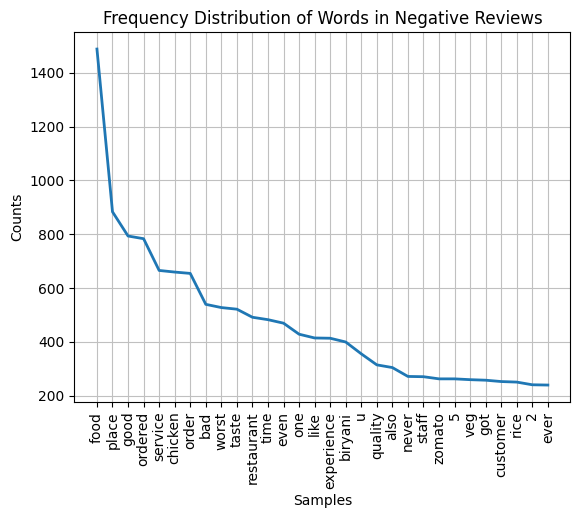

<Axes: title={'center': 'Frequency Distribution of Words in Negative Reviews'}, xlabel='Samples', ylabel='Counts'>

In [54]:
# Frequency distribution
freq_dist = FreqDist(all_tokens)

# Plot the most common words in negative reviews
freq_dist.plot(30, title='Frequency Distribution of Words in Negative Reviews')

From the graph, we can see a few notable points:

- Common Words: Words like "food", "place", "order", "service", and "chicken" appear to be the most frequently occurring in the dataset. This suggests these aspects are common points of discussion in negative reviews.

- Word Frequency Drop: There is a steep drop in frequency after the first few words, indicating that a small number of words are used very frequently, while most other words are used relatively infrequently.

- Potential Issues Highlighted: Besides generic words that are expected in restaurant reviews (such as "food", "place", "order"), the presence of words like "service", "time", "quality", and "experience" could indicate specific areas of concern for customers. For example, "service" and "time" might relate to the speed and quality of service, while "quality" could refer to the quality of food or overall experience.

- Additional Insight: The presence of words like "never" towards the right end of the plot could suggest strong negative feelings or dissatisfaction, as customers might be saying they would "never" return or recommend the place.

### 2. Data Preprocessing and Feature Engineering Steps

Let's perform data cleaning on all the reviews, regardless of the review score, for feature engineering and model training.

We will experiment and determine the best text normalization technique that improves model performance through the order combination of lemmatization and stemming.

This will help the fine-tuning the feature extraction phase.

- `X_stem` and `y_stem` for stemming first
- `X_lemma` and `y_lemma` for lemmatization first

In [55]:
# Initialize stemmer object
# lemmatizer, tokenizer and stop_words were initialized earlier in the code
stemmer = PorterStemmer()

In [56]:
# Tokenize and remove stopwords
reviews = df['Review'].apply(lambda x: [word.lower() for word in tokenizer.tokenize(x) if word.lower() not in stop_words])

# Stemming first, then lemmatization
stem_then_lem_reviews = reviews.apply(lambda x: ' '.join([lemmatizer.lemmatize(stemmer.stem(word)) for word in x]))

# Lemmatization first, then stemming
lem_then_stem_reviews = reviews.apply(lambda x: ' '.join([stemmer.stem(lemmatizer.lemmatize(word)) for word in x]))

Prepare the features and labels using TFIDF

In [57]:
# Create binary target variable based on the rating
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x > 3 else 0)

X_stem = stem_then_lem_reviews
X_lemma = lem_then_stem_reviews
# Both targets are the same, as the sentiment classification remains unchanged
y_stem = df['Sentiment']
y_lemma = df['Sentiment']

In [58]:
# Convert text data to numeric format using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_stem_tfidf = tfidf_vectorizer.fit_transform(stem_then_lem_reviews)
X_lemma_tfidf = tfidf_vectorizer.fit_transform(lem_then_stem_reviews)

# Split the data into train and test for both feature combinations
test_size = 0.2
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem_tfidf, df['Sentiment'], test_size=test_size, random_state=1103)
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(X_lemma_tfidf, df['Sentiment'], test_size=test_size, random_state=1103)

In [59]:
# Check the shape of the train and test data
X_train_lemma_percent = (X_train_lemma.shape[0]/df_size)*100
X_test_lemma_percent = (X_test_lemma.shape[0]/df_size)*100

print(f"Training lemma data shape: {X_train_lemma.shape}, {X_train_lemma_percent:.1f}%")
print(f"Testing lemma data shape: {X_test_lemma.shape}, {X_test_lemma_percent:.1f}%")

Training lemma data shape: (7964, 11197), 80.0%
Testing lemma data shape: (1991, 11197), 20.0%


11197 represents the number of features for each sample, which means there were 11197 distinct terms identified by the TF-IDF vectorizer.

If we were to add up 7964 and 1991, we would get 9955. This is due to data cleaning steps where rows might were dropped. The size after cleaning missing values 9955, so train test split was done successfully.

### 3. Fitting into various models

We will train 2 different models on our data: Random Forest and BERT Transformer.

For Random Forest we will try both combination sets, stemming first and lemmatizing first, to see which one performs best.

Since BERT Transformer has its unique data processing and tokenization method, we won't use either combination and will tokenize the reviews specifically for BERT.

#### 3.1 Random Forest

In [61]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=1103)

In [62]:
# Stemming first, then lemmatization
# Train the model
rf_classifier.fit(X_train_stem, y_train_stem)

RandomForestClassifier(max_depth=15, n_estimators=300, random_state=1103)

In [63]:
# Predicting : Stemming first
y_stem_pred = rf_classifier.predict(X_test_stem)

# Evaluate predictions
print("Evaluation Random Forest; Stemming first then lemmatization")
accuracy = accuracy_score(y_test_stem, y_stem_pred)
print(f'Accuracy: {accuracy:.2%}')
print("Classification Report:\n", classification_report(y_test_stem, y_stem_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_stem, y_stem_pred))

Evaluation Random Forest; Stemming first then lemmatization
Accuracy: 75.44%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.31      0.48       706
           1       0.73      1.00      0.84      1285

    accuracy                           0.75      1991
   macro avg       0.85      0.66      0.66      1991
weighted avg       0.82      0.75      0.71      1991

Confusion Matrix:
 [[ 222  484]
 [   5 1280]]


In [64]:
# Lemmatization first, then stemming
# Train the model
rf_classifier.fit(X_train_lemma, y_train_lemma)

RandomForestClassifier(max_depth=15, n_estimators=300, random_state=1103)

In [65]:
# Predicting : Lemmatization first
y_lemma_pred = rf_classifier.predict(X_test_lemma)

# Evaluate predictions
print("Evaluation Random Forest; Lemmatization first then stemming")
accuracy = accuracy_score(y_test_lemma, y_lemma_pred)
print(f'Accuracy: {accuracy:.2%}')
print("Classification Report:\n", classification_report(y_test_lemma, y_lemma_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_lemma, y_lemma_pred))

Evaluation Random Forest; Lemmatization first then stemming
Accuracy: 75.89%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.33      0.49       706
           1       0.73      1.00      0.84      1285

    accuracy                           0.76      1991
   macro avg       0.85      0.66      0.67      1991
weighted avg       0.82      0.76      0.72      1991

Confusion Matrix:
 [[ 231  475]
 [   5 1280]]


#### 3.2 Transformers

IMPORTANT: The implementation of the BERT model for sequence classification, including data preprocessing, model initialization, and training, was based on methods provided by the Hugging Face Transformers library. The specific techniques for data preparation, model training, and optimization settings were adapted to suit the requirements of our sentiment analysis task, leveraging the extensive resources available through Hugging Face's documentation and community examples.

References:
- Hugging Face Transformers Documentation:
  - "Transformers: State-of-the-art Natural Language Processing for Pytorch and TensorFlow 2.0." Hugging Face. Available at: https://huggingface.co/transformers/

- BERT Model Configuration and Training:
  - Wolf, Thomas, et al. "Huggingface's Transformers: State-of-the-art Natural Language Processing." ArXiv, 2020. Available at: https://arxiv.org/abs/1910.03771

We first need to format the data correctly for BERT, which includes non-traditional tokenization and converting the labels into a format that BERT can understand.

In [66]:
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [67]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [68]:
# List to hold input IDs and attention masks
input_ids = []
attention_masks = []

# Loop through each item in the DataFrame's 'Review' column
for text in df['Review']:
    encoded_dict = tokenizer.encode_plus(
        text                          # Review text
        , add_special_tokens=True     # Adding '[CLS]' and '[SEP]' at the start and end
        , max_length=256              # Pad or truncate all sentences to the same length
        , pad_to_max_length=True      # Pad all sentences to the max_length
        , return_attention_mask=True  # Construct attention masks
        , return_tensors='pt'         # Return tensors
    )

    # Add the encoded result to the lists
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Load labels and convert it to a tensor
labels = torch.tensor(df['Sentiment'].values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Use DataLoader to batch the data, shuffle it, and load it asynchronously using multiprocessing workers.

In [72]:
# Set the batch size
batch_size = 32

# Create the DataLoader
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")

Device being used: cuda


Loading a pre-trained BERT model with a classification head

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased"
    , num_labels = 2
    , output_attentions = False
    , output_hidden_states = False
)

# Use device selected earlier
model.to(device)

Set up AdamW optimizer and the learning rate scheduler for training.

We use this variant of the Adam optimizer since it is better suited for these models as per the recommendations in the original BERT paper.

In [74]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook has 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Loop

In [75]:
# Number of training epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs
total_steps = len(prediction_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [81]:
# Training loop
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(prediction_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(prediction_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set (e.g., `output_attentions`). For our
        # useage here, it returns the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(prediction_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    312.    Elapsed: 12:00:51 AM.
  Batch    80  of    312.    Elapsed: 12:01:42 AM.
  Batch   120  of    312.    Elapsed: 12:02:32 AM.
  Batch   160  of    312.    Elapsed: 12:03:23 AM.
  Batch   200  of    312.    Elapsed: 12:04:13 AM.
  Batch   240  of    312.    Elapsed: 12:05:04 AM.
  Batch   280  of    312.    Elapsed: 12:05:54 AM.

  Average training loss: 0.24
  Training epoch took: 12:06:34 AM

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    312.    Elapsed: 12:00:50 AM.
  Batch    80  of    312.    Elapsed: 12:01:41 AM.
  Batch   120  of    312.    Elapsed: 12:02:31 AM.
  Batch   160  of    312.    Elapsed: 12:03:22 AM.
  Batch   200  of    312.    Elapsed: 12:04:12 AM.
  Batch   240  of    312.    Elapsed: 12:05:03 AM.
  Batch   280  of    312.    Elapsed: 12:05:53 AM.

  Average training loss: 0.16
  Training epoch took: 12:06:33 AM

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    312.

In [ ]:
# Evaluation of BERT

# Assuming you have validation data split
# validation_inputs, validation_masks, validation_labels = ...

# Create the DataLoader for the validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

Evaluation loop

In [ ]:
# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

# Report the final accuracy for this validation run.
# print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

In [ ]:
# Placeholder for predictions and true labels
predictions , true_labels = [], []

# Predict
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten the predictions and true labels lists
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the accuracy of the model
model_accuracy = accuracy_score(flat_true_labels, flat_predictions)
model_precision = precision_score(flat_true_labels, flat_predictions)
model_recall = recall_score(flat_true_labels, flat_predictions)
model_f1 = f1_score(flat_true_labels, flat_predictions)

print("Accuracy: {:.4f}".format(model_accuracy))
print("Precision: {:.4f}".format(model_precision))
print("Recall: {:.4f}".format(model_recall))
print("F1 Score: {:.4f}".format(model_f1))

#### 4. Evaluation

In [ ]:
# TODO

#### 5. Using our models with other datasets

In [ ]:
# TODO